
Sphere: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=53392a242acc87d6f5e13209afe2d78dcce767f8117c5a1ae9eeecfdecd62cee
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Sphere'
n_test = 500
eps = 1e-08

util = 'ERM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Sphere(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * ( x1_training ** 2
                            + x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]
    
    def ERM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm):
    
        return self.f(y_global_orig, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1659620315.9027278

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.06634807 -4.83935541]	 39.954547453636486	 1.275455677703416	 3.53437872101177	 4.143326988760059
2  	 [5.12       4.36601704]	 45.276504812089044	 1.275455677703416	 3.3568462859465584	 3.6722590151449417
3  	 [-5.12  5.12]	 52.4288	 1.275455677703416	 3.241858970139179	 3.474168327181999
4  	 [ 3.13505906 -0.10250276]	 9.839102151045365	 1.275455677703416	 3.1368067655372	 3.3897397652465955
5  	 [ 0.39359091 -2.98330829]	 9.055042152520045	 1.275455677703416	 2.6786780

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.7196174943107576	 3.818091952834305
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 2.798703843810863	 3.8878653213842806
3  	 [-9.87492382e-04  5.12000000e+00]	 26.214400975141206	 0.6972563370202991	 3.6921202610683306	 3.9130965146368912
4  	 [-5.12  5.12]	 52.4288	 0.6972563370202991	 3.1634962534089817	 3.3447516226975793
5  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.72597

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 1.82812718 -3.59088954]	 16.236536649853953	 4.59675431006429	 2.0399276094355456	 3.352068685547001
2  	 [-4.53043495  4.96162351]	 45.14254870996783	 4.59675431006429	 2.79972758909691	 3.7896077477636654
3  	 [ 5.12       -0.54190283]	 26.50805867302198	 4.59675431006429	 2.780928798522941	 3.1588928927301287
4  	 [ 5.12 -5.12]	 52.4288	 4.59675431006429	 3.1263154074637294	 3.062370922779278
5  	 [-0.4099214  5.12     ]	 26.382435550631943	 4.59675431006429	 2.9148847047792943	 3.

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=opt)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-2.49848471  4.68810004]	 28.220707791149493	 6.844040613967918	 2.794170909695304	 3.7079038501476522
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.8259589554724145	 3.761460371073577
3  	 [1.79747406 5.12      ]	 29.44531299543434	 6.844040613967918	 3.4843510125105737	 3.444917089999066
4	 [0.64168211 1.1215281 ]	 1.6695812076669763	 1.6695812076669763	 3.164288637968995	 3.4077853780945215
5  	 [-0.95719549 -5.12      ]	 27.130623214897394	 1.6695812076669763	 2.90806597956

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.395109559366356	 4.274627789641052
2  	 [5.12       4.85435802]	 49.77919180861997	 1.3234068721819314	 4.142476534465595	 3.7350358899578877
3  	 [-5.12       -0.04785525]	 26.216690125239175	 1.3234068721819314	 3.3645087932405877	 3.651697378557545
4  	 [0.97324314 5.12      ]	 27.16160220060327	 1.3234068721819314	 3.345550810592022	 3.3320754246350037
5  	 [-5.12 -5.12]	 52.4288	 1.3234068721819314	

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [5.12 5.12]	 52.428799999999995	 0.7844720799352826	 4.050258439347114	 3.861809711766971
2  	 [-3.32779551 -5.12      ]	 37.28862295424252	 0.7844720799352826	 3.6505232924858	 3.605862867209806
3  	 [0.08327687 5.12      ]	 26.2213350377559	 0.7844720799352826	 3.262111395301113	 3.4007395176823967
4  	 [-5.12  5.12]	 52.4288	 0.7844720799352826	 3.18683262856039	 3.9117809593365678
5  	 [2.3453467  1.79754942]	 8.73183508585215	 0.7844720799352826	 2.8158274563067147	

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 3.2041352431907013	 3.5195435779894733
2  	 [ 5.12 -5.12]	 52.4288	 5.622519010932044	 3.72535187905791	 3.757323283374026
3  	 [3.33439653 5.12      ]	 37.33260019226747	 5.622519010932044	 3.949411660861772	 3.7095861053294192
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.8896328289336957	 2.911219880677074
5	 [ 1.22343688 -0.77271602]	 2.093887849321066	 2.093887849321066	 3.1486034732778836	 3.0588

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [-0.00463248  2.0748902 ]	 4.3051908167202	 0.10287109474532606	 3.014594132539912	 3.8418214925822123
2  	 [ 5.12       -4.98863682]	 51.10089734554798	 0.10287109474532606	 3.2611654003233874	 4.022637051438944
3  	 [-4.17756311  5.12      ]	 43.66643351030382	 0.10287109474532606	 2.53379345021843	 3.426198078044278
4  	 [-5.12       -0.16117147]	 26.240376243605684	 0.10287109474532606	 3.3425351865144832	 3.546972194182447
5  	 [ 1.199101   -3.61513883]	 14.50707

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 3.0905261515009332	 3.114117452502966
2  	 [-2.26307256  5.12      ]	 31.33589739294164	 7.349882113053805	 3.24665874172362	 3.967433650566336
3  	 [ 4.78877615 -1.12845565]	 24.205789180310127	 7.349882113053805	 2.741484617146401	 2.9921549530996576
4	 [0.55110058 1.33498138]	 2.0858871302031265	 2.0858871302031265	 2.791109931225452	 3.1214978513951688
5  	 [ 4.05899696 -5.12      ]	 42.68985632410142	 2.08588

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.36616944]	 26.348480057234802	 7.941821858928501	 3.511751238630375	 3.5733460396586043
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 3.0868716237908163	 3.069277758482444
3  	 [-5.12     -0.596191]	 26.569843714046797	 7.941821858928501	 2.85124516827448	 3.232018548477503
4  	 [-0.58327257  5.12      ]	 26.554606894666318	 7.941821858928501	 3.2111176541869906	 3.4308421313878594
5  	 [-5.12  5.12]	 52.4288	 7.941821858928501	 3.022888035352893	 3.075715825533881

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 2.9158170513702655	 3.7829261858843455
2  	 [-5.12  5.12]	 52.4288	 0.6899456214148796	 2.223662794070773	 3.22741835715085
3  	 [ 5.12       -0.71940645]	 26.73194564620236	 0.6899456214148796	 3.079335528690304	 3.233738782454868
4  	 [0.92481282 5.12      ]	 27.069678751912193	 0.6899456214148796	 2.404853958634682	 2.355575680473397
5  	 [-0.19948548 -2.4701054 ]	 6.141215126138828	 0.6899456214148796	 2.

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [4.61121049 2.73895066]	 28.76511294085281	 5.993464196233534	 3.78948948641799	 3.4054397137486765
2  	 [-5.12 -5.12]	 52.4288	 5.993464196233534	 3.5092160185367227	 3.599993554837231
3  	 [0.38783121 5.12      ]	 26.364813043813236	 5.993464196233534	 3.1962499276111362	 3.2329327412274
4  	 [-0.48765728 -3.66213155]	 13.649017110780735	 5.993464196233534	 2.992852208092012	 2.4279017150924225
5	 [ 1.54769251 -0.13151794]	 2.4126490694132356	 2.4126490694132356	 2.94783302322

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-4.10876704 -2.60547476]	 23.670465283396044	 7.271500601275535	 3.0532147130708753	 3.0988437564543267
2  	 [-3.69153184  5.12      ]	 39.84180735635964	 7.271500601275535	 3.068254844082413	 3.548920657102279
3  	 [-0.59462201 -5.12      ]	 26.567975331219102	 7.271500601275535	 2.965812351956974	 3.204735367735101
4	 [-2.36987646  1.04354129]	 6.705292861685945	 6.705292861685945	 2.9894999902429493	 3.0546932354176644
5  	 [ 5.12 -5.12]	 52.4288	 6.705292861685945	 3.44599436369

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [-4.80213133 -4.31153952]	 41.64983829336841	 3.480496204392171	 3.8400259412105604	 3.7945970786431418
2  	 [5.0187282  4.98604062]	 50.048233788905506	 3.480496204392171	 3.707504701833349	 3.939640019978396
3  	 [-5.12        0.82504364]	 26.895097010879343	 3.480496204392171	 2.6968582929683325	 3.7421532164191964
4  	 [ 5.12       -0.13884208]	 26.233677124391313	 3.480496204392171	 2.943885611432247	 3.3408185543249873
5	 [-1.65340757 -0.00223578]	 2.7337615869575975	 2.73

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12 5.12]	 52.4288	 5.383887924980681	 3.6268311811072125	 3.721858191527722
2  	 [-5.12        4.76091708]	 48.88073146379702	 5.383887924980681	 2.9123848392279306	 3.601470267170632
3  	 [-0.01242886  5.12      ]	 26.214554476647972	 5.383887924980681	 3.0721099410659276	 3.2822859017809924
4  	 [2.28786923 1.08382166]	 6.409015018813981	 5.383887924980681	 2.792940764128972	 2.8138951198072375
5  	 [-0.11958936 -5.12      ]	 26.228701615906857	 5.383887924980681	 3.28031

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.83129877 5.12      ]	 34.23065270942368	 8.084978900492077	 3.563205465087404	 3.6174225241180715
2  	 [5.12       0.42509821]	 26.395108490220043	 8.084978900492077	 3.3095812871832018	 3.2256755203783145
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.4151240776085343	 3.595946879436693
4	 [0.93098764 1.14344631]	 2.1742074560978004	 2.1742074560978004	 2.8810953040020957	 3.129011655427146
5  	 [-0.70627765  3.72196518]	 14.351852933725974	 2.1742074560978004	 2.918880

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.5265385281530786	 4.270374135697341
2  	 [-5.12  5.12]	 52.4288	 2.5824114132885994	 3.188495964090029	 3.4253519200600118
3  	 [-0.07230436  5.12      ]	 26.21962792071718	 2.5824114132885994	 3.5392448294457317	 3.319984524174325
4  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.644895140657953	 3.7833450126301247
5  	 [ 0.85279436 -2.81535848]	 8.653501575763329	 2.5824114132885994	 2.7447807026918585	 2.8

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.12        2.45238392]	 32.228586914144365	 2.3742017032787373	 3.1207138130122365	 3.696046577094346
2  	 [-2.04721775 -0.54047181]	 4.483210300083269	 2.3742017032787373	 2.6122895646681945	 2.5590793004629147
3  	 [-5.12       -1.86903584]	 29.707694961288407	 2.3742017032787373	 2.929321014862238	 3.114479992682161
4  	 [-2.25562474  5.12      ]	 31.302242986414406	 2.3742017032787373	 2.979085302015675	 3.3516966796355194
5  	 [ 1.0136057 -5.12     ]	 27.241796523779

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 5.12       -4.68768694]	 48.188808813073365	 12.957869519084127	 3.581359316945775	 4.378859899613629
2	 [ 1.47881359 -1.38363932]	 4.101347412748054	 4.101347412748054	 3.4574000598515533	 3.367345591576622
3  	 [5.12 5.12]	 52.4288	 4.101347412748054	 3.169324777595818	 3.2817157559959353
4  	 [-5.12       -1.05768127]	 27.333089670096577	 4.101347412748054	 3.024705488448154	 3.105420896564976
5  	 [-1.25760048  5.12      ]	 27.795958959660503	 4.101347412748054	 2.702

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-3.43642144 -5.12      ]	 38.02339231335999	 1.579257056101869	 3.032275020366754	 2.852782274088817
2  	 [ 5.12 -5.12]	 52.4288	 1.579257056101869	 2.9292540641325178	 3.798104382620611
3  	 [ 5.12       -0.75178202]	 26.779576205551827	 1.579257056101869	 2.6541731098324375	 3.1109704230989177
4  	 [-2.73893851  5.12      ]	 33.71618417131032	 1.579257056101869	 3.115019853684389	 3.1015959285173875
5  	 [-5.12       -1.72983973]	 29.206745486724564	 1.579257056101869	 2.9477676

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1659621299.6397238

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 5.812071182014687	 1.275455677703416	    	    
init	 [-5.1188288  -2.02411446]	 30.299447634857913	 1.275455677703416	    	    
init	 [-3.61721968 -4.17445279]	 30.510334291475417	 1.275455677703416	    	    
init	 [-3.21269544 -1.58145816]	 12.822421857501787	 1.275455677703416	    	    
init	 [-1.05710106  0.39748336]	 1.275455677703416	 1.275455677703416	    	    
1  	 [ 4.04077223 -4.24914728]	 34.383092818836786	 1.275455677703416	 3.53437872101177	 4.143326988760059
2  	 [5.12       4.53450932]	 46.77617472892402	 1.275455677703416	 3.3905590231465306	 3.69401996784445
3  	 [2.91892823 0.34368058]	 8.638258337172488	 1.275455677703416	 3.3065219655749645	 3.4154037738523875
4  	 [-4.89963078  4.58717018]	 45.0485120087331	 1.275455677703416	 3.2296130951033475	 3.987553531995675
5  	 [0.99495261 5.12      ]	 27.204330694870038	 1.2754556

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 23.995884788327533	 0.6972563370202991	    	    
init	 [ 0.50854377 -0.6622987 ]	 0.6972563370202991	 0.6972563370202991	    	    
init	 [-0.81543371 -1.73737143]	 3.683391625826377	 0.6972563370202991	    	    
init	 [-3.02439799  1.2213347 ]	 10.638641624769724	 0.6972563370202991	    	    
init	 [-2.05153614 -2.3876887 ]	 9.90985788235879	 0.6972563370202991	    	    
1  	 [4.81874241 3.07464552]	 32.673723450709105	 0.6972563370202991	 3.7196174943107576	 3.818091952834305
2  	 [ 4.84260546 -3.96517156]	 39.173413151255836	 0.6972563370202991	 2.798703843810863	 3.8878653213842806
3  	 [0.03041468 5.12      ]	 26.21532505286182	 0.6972563370202991	 3.6921202610683306	 3.9130965146368912
4  	 [-5.12 -5.12]	 52.4288	 0.6972563370202991	 3.1632930320844332	 3.345021594479179
5  	 [ 2.9900556  -0.39151404]	 9.093715754784018	 0.697256337020299

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 4.813587005218131	 4.59675431006429	    	    
init	 [-2.14113547  0.11087468]	 4.59675431006429	 4.59675431006429	    	    
init	 [4.02377681 4.05804123]	 32.65847846685941	 4.59675431006429	    	    
init	 [-3.83400642 -2.99783293]	 23.686607498512902	 4.59675431006429	    	    
init	 [-4.59297584 -0.6061072 ]	 21.462792989409664	 4.59675431006429	    	    
1  	 [ 2.87039579 -1.98286482]	 12.170924921871098	 4.59675431006429	 2.0399276094355456	 3.352068685547001
2  	 [-3.41122163  4.97297824]	 36.36694557321632	 4.59675431006429	 2.8121940821273066	 3.9193918052213266
3  	 [5.12       0.49455483]	 26.45898448030247	 4.59675431006429	 2.7713906872047733	 3.379196171740737
4  	 [-0.0698226 -5.12     ]	 26.219275195083885	 4.59675431006429	 2.839104967053326	 3.204646829254006
5  	 [ 3.17715702 -4.87519394]	 33.861842705659186	 4.59675431006429	 

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 23.1051368481516	 6.844040613967918	    	    
init	 [4.84028785 2.19971578]	 28.267135924302462	 6.844040613967918	    	    
init	 [ 2.02474316 -2.90724357]	 12.551650027390728	 6.844040613967918	    	    
init	 [ 4.87705042 -5.05620219]	 49.3508013219099	 6.844040613967918	    	    
init	 [-2.52946061 -0.66773471]	 6.844040613967918	 6.844040613967918	    	    
1  	 [-1.25015937  4.53961839]	 22.17103353082063	 6.844040613967918	 2.794170909695304	 3.7079038501476522
2  	 [-5.12 -5.12]	 52.4288	 6.844040613967918	 3.66931877100548	 3.8025957634125
3  	 [-0.96232943 -5.12      ]	 27.140477939595495	 6.844040613967918	 3.4202445203403955	 3.510096350290938
4	 [0.65728467 1.17944657]	 1.8231173619068866	 1.8231173619068866	 3.135594206098595	 3.3394639944779945
5  	 [-5.12        2.35532478]	 31.76195481241593	 1.8231173619068866	 2.85370064261409

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 22.516097589112718	 1.3234068721819314	    	    
init	 [-3.00319585  4.2865757 ]	 27.393916517947076	 1.3234068721819314	    	    
init	 [-0.11866943  1.14425716]	 1.3234068721819314	 1.3234068721819314	    	    
init	 [2.72289645 0.1886002 ]	 7.449735113237491	 1.3234068721819314	    	    
init	 [-2.08076286 -3.19773462]	 14.555080786026249	 1.3234068721819314	    	    
1  	 [ 4.32895605 -5.09732646]	 44.722597532365825	 1.3234068721819314	 4.395109559366356	 4.274627789641052
2  	 [5.11980621 5.12      ]	 52.426815627780805	 1.3234068721819314	 4.142476534465595	 3.7350358899578877
3  	 [-5.12       -0.29950628]	 26.30410400876508	 1.3234068721819314	 3.3803906609369556	 3.6550016707308655
4  	 [0.97659638 5.12      ]	 27.16814048622748	 1.3234068721819314	 3.3640352516746193	 3.3595741818220506
5  	 [-5.12 -5.12]	 52.4288	 1.323406872181931

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 19.143839911819178	 0.7844720799352826	    	    
init	 [ 3.28938622 -4.69302655]	 32.84455992822337	 0.7844720799352826	    	    
init	 [-4.0175956   0.97333314]	 17.088451781196223	 0.7844720799352826	    	    
init	 [ 0.30532979 -0.83141193]	 0.7844720799352826	 0.7844720799352826	    	    
init	 [-1.68542362  1.25459899]	 4.414671405342624	 0.7844720799352826	    	    
1  	 [4.83179343 5.12      ]	 49.56062772375974	 0.7844720799352826	 4.050258439347114	 3.861809711766971
2  	 [-5.12 -5.12]	 52.4288	 0.7844720799352826	 3.63557818120335	 3.585563563768808
3  	 [-0.14148483  5.12      ]	 26.23441795614648	 0.7844720799352826	 3.4034205867002965	 3.528345409529991
4  	 [-0.87301974 -4.37692616]	 19.919646083511967	 0.7844720799352826	 3.2126827651934797	 3.990721238903689
5  	 [2.3199126  1.72340131]	 8.3521065217221	 0.7844720799352826	 2.5

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 27.039544996254122	 5.622519010932044	    	    
init	 [-0.63068947  2.28828342]	 5.634010222398341	 5.622519010932044	    	    
init	 [4.8946126  0.39419771]	 24.112624368867845	 5.622519010932044	    	    
init	 [ 0.01147355 -4.38219639]	 19.20377688135857	 5.622519010932044	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622519010932044	 5.622519010932044	    	    
1  	 [-5.12 -5.12]	 52.4288	 5.622519010932044	 3.2041352431907013	 3.5195435779894733
2  	 [3.33284689 5.12      ]	 37.32226836951393	 5.622519010932044	 3.72535187905791	 3.757323283374026
3  	 [ 4.52356741 -4.16736796]	 37.82961780903664	 5.622519010932044	 3.383649535399332	 3.405184932087415
4  	 [-4.02558214 -1.33646422]	 17.991448177385568	 5.622519010932044	 2.8896328289336957	 2.911219880677074
5	 [ 1.20811597 -0.75568934]	 2.030610584581081	 2.030610584581081	 3.153

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 37.641767782829874	 0.10287109474532606	    	    
init	 [3.78055209 0.31596228]	 14.392406282091054	 0.10287109474532606	    	    
init	 [-2.73686192 -5.00327624]	 32.52318635319257	 0.10287109474532606	    	    
init	 [-0.7119993  -0.99992207]	 1.5067871566831337	 0.10287109474532606	    	    
init	 [ 0.23218863 -0.22126801]	 0.10287109474532606	 0.10287109474532606	    	    
1  	 [0.02151874 1.98688278]	 3.948166237617704	 0.10287109474532606	 3.014594132539912	 3.8418214925822123
2  	 [-5.03492225  2.95509263]	 34.08301446412634	 0.10287109474532606	 3.2616659416645977	 4.020368214528524
3  	 [-5.12       -1.47949147]	 28.403294996072056	 0.10287109474532606	 2.678630719586354	 3.712905023214873
4  	 [ 2.57783575 -4.69282903]	 28.667881423739296	 0.10287109474532606	 3.2554289336841946	 3.7819411592573147
5  	 [-0.41663549  5.12      ]	 26.38

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138244697862262	 7.349882113053805	    	    
init	 [-0.04328148 -3.74958562]	 14.061265633999861	 7.349882113053805	    	    
init	 [-3.66478248 -2.88195916]	 21.736319271030034	 7.349882113053805	    	    
init	 [-0.83447623 -2.57944404]	 7.349882113053805	 7.349882113053805	    	    
init	 [-4.25922917 -1.58209393]	 20.64405433050371	 7.349882113053805	    	    
1  	 [3.69491889 4.82146316]	 36.89893267190826	 7.349882113053805	 3.0905261515009332	 3.114117452502966
2  	 [ 5.12       -0.96381407]	 27.143337562162976	 7.349882113053805	 3.24665874172362	 3.967433650566336
3  	 [-1.76909223  4.32341908]	 21.821639851175718	 7.349882113053805	 2.681872080903368	 4.07978119548468
4	 [0.99478922 1.03537881]	 2.061614860229406	 2.061614860229406	 2.850761209251135	 3.4557538994417047
5  	 [ 2.83123084 -3.26291426]	 18.662477502508857	 2.0616148

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 31.80263747150094	 7.941821858928501	    	    
init	 [1.36855793 2.54775176]	 8.363989812138083	 7.941821858928501	    	    
init	 [-0.01528819 -2.81808235]	 7.941821858928501	 7.941821858928501	    	    
init	 [-3.09183626  2.66783449]	 16.67679237031191	 7.941821858928501	    	    
init	 [-3.38830503 -4.2154003 ]	 29.25021071405309	 7.941821858928501	    	    
1  	 [ 5.12       -0.36312462]	 26.346259491136617	 7.941821858928501	 3.511751238630375	 3.5733460396586043
2  	 [5.12 5.12]	 52.4288	 7.941821858928501	 3.086865576892121	 3.0692879647129487
3  	 [-4.2170303  -0.72747913]	 18.31257046398536	 7.941821858928501	 2.851282691237914	 3.1369049341370427
4  	 [-0.4936122  5.12     ]	 26.458052999244767	 7.941821858928501	 3.3664462667887833	 3.3367211411241744
5	 [ 0.09223992 -0.04557007]	 0.010584834493645248	 0.010584834493645248	 3.03912

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 34.93137118861299	 0.6899456214148796	    	    
init	 [-0.37664229  2.30332343]	 5.447158259491397	 0.6899456214148796	    	    
init	 [-0.81711509 -0.14922651]	 0.6899456214148796	 0.6899456214148796	    	    
init	 [-4.98912446 -0.12931474]	 24.908085165573997	 0.6899456214148796	    	    
init	 [4.52410012 3.59214172]	 33.37096399795931	 0.6899456214148796	    	    
1  	 [ 3.03550212 -4.46785095]	 29.17596522689979	 0.6899456214148796	 2.9158170513702655	 3.7829261858843455
2  	 [ 4.94058088 -0.61742327]	 24.79055096336676	 0.6899456214148796	 2.223662794070773	 3.22741835715085
3  	 [-1.19896852  5.12      ]	 27.65192550764565	 0.6899456214148796	 3.1612978909720906	 3.4636628425458573
4  	 [ 1.19946032 -1.29909369]	 3.1263494758818773	 0.6899456214148796	 2.4435013002454946	 2.7790996574064173
5  	 [-3.74685325  2.91006388]	 22.5073810596

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 18.583618467979093	 5.993464196233534	    	    
init	 [-2.42365424  0.34549139]	 5.993464196233534	 5.993464196233534	    	    
init	 [-4.97075238  4.28796936]	 43.09506052206225	 5.993464196233534	    	    
init	 [ 4.10332011 -4.77776458]	 39.66427028607538	 5.993464196233534	    	    
init	 [ 4.6791612  -3.71497655]	 35.6956003298903	 5.993464196233534	    	    
1  	 [5.12 5.12]	 52.4288	 5.993464196233534	 3.78948948641799	 3.4054397137486765
2  	 [-5.12 -5.12]	 52.4288	 5.993464196233534	 3.446748855546685	 3.2031242752618656
3	 [2.235001   0.81687341]	 5.662511638051637	 5.662511638051637	 3.0204650036311533	 2.8480926972286826
4  	 [0.22625775 5.12      ]	 26.265592570173133	 5.662511638051637	 3.0093179016819898	 3.1028963177612185
5  	 [-0.46141072 -4.08348715]	 16.887767167145142	 5.662511638051637	 2.7789980738778413	 2.7877091591674

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 15.30954934064491	 7.271500601275535	    	    
init	 [3.32061217 4.76927179]	 33.772418600555795	 7.271500601275535	    	    
init	 [ 4.83943541 -0.47667971]	 23.647358595121606	 7.271500601275535	    	    
init	 [1.11659482 2.82139151]	 9.20703403927425	 7.271500601275535	    	    
init	 [1.45012065 2.27346667]	 7.271500601275535	 7.271500601275535	    	    
1  	 [-5.12       -3.40131911]	 37.783371661224805	 7.271500601275535	 3.0532147130708753	 3.0988437564543267
2  	 [-4.19995421  2.26772811]	 22.782206181656306	 7.271500601275535	 2.601932491242373	 3.4428651107804775
3  	 [-0.87534118 -5.12      ]	 26.980622176658677	 7.271500601275535	 3.027176764168648	 3.1175437594614857
4	 [-0.81232238 -0.97569418]	 1.6118467877293887	 1.6118467877293887	 2.8405184913212898	 2.96984919370988
5  	 [-0.949167  5.12    ]	 27.11531798827151	 1.611846787

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 7.844770612568215	 3.480496204392171	    	    
init	 [ 3.7931795  -5.03759925]	 39.765616906968944	 3.480496204392171	    	    
init	 [-1.94830412  4.68586229]	 25.753194366239512	 3.480496204392171	    	    
init	 [ 0.13431513 -1.86076749]	 3.480496204392171	 3.480496204392171	    	    
init	 [ 0.40140736 -2.85434939]	 8.308438305616814	 3.480496204392171	    	    
1  	 [5.12       4.96637578]	 50.87928837612024	 3.480496204392171	 3.8400259412105604	 3.7945970786431418
2  	 [-5.12 -5.12]	 52.4288	 3.480496204392171	 3.7729090735130733	 3.773857287364641
3  	 [-5.12        0.39224345]	 26.36825492560946	 3.480496204392171	 2.7999335918963975	 3.7186186258096816
4  	 [ 4.71081134 -0.06617282]	 22.196122302567513	 3.480496204392171	 2.92645636432267	 3.3005214878937768
5  	 [-2.73893387 -2.07532497]	 11.808732483230772	 3.480496204392171	 2.73105

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 23.57006045912445	 5.383887924980681	    	    
init	 [-4.56332069 -1.41784631]	 22.834183843344235	 5.383887924980681	    	    
init	 [-2.29989449  0.3072023 ]	 5.383887924980681	 5.383887924980681	    	    
init	 [-1.9873903  -2.00218256]	 7.958455228543059	 5.383887924980681	    	    
init	 [-3.97576933 -2.5610341 ]	 22.365637431409507	 5.383887924980681	    	    
1  	 [5.12       2.66905492]	 33.338254155703545	 5.383887924980681	 3.6268311811072125	 3.721858191527722
2  	 [-0.07181799  5.12      ]	 26.219557824040624	 5.383887924980681	 2.9982333128743788	 3.6813970115354286
3  	 [-4.9338141   3.75227743]	 38.422107450632986	 5.383887924980681	 3.100929309132633	 3.4238646567586195
4	 [1.14668048 1.21268204]	 2.7854738588745263	 2.7854738588745263	 2.9238815199303363	 2.6402719854210472
5  	 [-0.94535118 -5.12      ]	 27.10808884984728	 2.

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.084978900492077	 8.084978900492077	    	    
init	 [ 0.51918292 -4.65303603]	 21.92029520206884	 8.084978900492077	    	    
init	 [-1.42613673 -2.83565116]	 10.074783446012654	 8.084978900492077	    	    
init	 [ 1.9325559  -3.44339021]	 15.591708419712269	 8.084978900492077	    	    
init	 [-4.39987336  4.51595121]	 39.75270093978162	 8.084978900492077	    	    
1  	 [2.142749   4.83374619]	 27.956475467604665	 8.084978900492077	 3.563205465087404	 3.6174225241180715
2  	 [5.12       0.52365354]	 26.488613032595683	 8.084978900492077	 3.4693327534289593	 3.521815258898298
3  	 [-5.12 -5.12]	 52.4288	 8.084978900492077	 3.393196068361103	 3.7061413010159057
4	 [0.95143676 0.73821385]	 1.4501916083886843	 1.4501916083886843	 2.8875629561059863	 3.319427479625143
5  	 [-0.94162881  2.97772967]	 9.753538835641207	 1.4501916083886843	 3.1337696

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.519153970964611	 2.5824114132885994	    	    
init	 [-3.15882714 -4.42470033]	 29.556161939946307	 2.5824114132885994	    	    
init	 [2.93873111 1.60085526]	 11.198878112253603	 2.5824114132885994	    	    
init	 [1.40821398 0.77417363]	 2.5824114132885994	 2.5824114132885994	    	    
init	 [-4.71999574 -1.45598869]	 24.39826283453718	 2.5824114132885994	    	    
1  	 [ 4.96008736 -4.44720822]	 44.38012757656366	 2.5824114132885994	 3.5265385281530786	 4.270374135697341
2  	 [-1.2187706  5.12     ]	 27.69980178179575	 2.5824114132885994	 3.188495964090029	 3.4253519200600118
3  	 [5.12 5.12]	 52.4288	 2.5824114132885994	 3.4732401014805325	 3.4033849593043843
4  	 [ 0.90895521 -3.03873066]	 10.060083594544418	 2.5824114132885994	 3.503040224827962	 3.848922220497895
5  	 [-4.82714937  2.72330661]	 30.717769889097866	 2.5824114132885994	 2

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3742017032787373	 2.3742017032787373	    	    
init	 [ 3.87687906 -3.25795609]	 25.644469161882945	 2.3742017032787373	    	    
init	 [3.60686662 2.56139557]	 19.570234102364928	 2.3742017032787373	    	    
init	 [1.70088108 4.99604939]	 27.853505942237412	 2.3742017032787373	    	    
init	 [-2.48864335 -4.83014733]	 29.523668919355142	 2.3742017032787373	    	    
1  	 [-5.00718904  2.9174042 ]	 33.58318939621877	 2.3742017032787373	 3.1207138130122365	 3.696046577094346
2  	 [-2.20629533 -0.4515277 ]	 5.071616345341137	 2.3742017032787373	 2.620976316505377	 2.5356535751085905
3  	 [-1.81231852  4.68785853]	 25.260516000683577	 2.3742017032787373	 2.989737693669957	 3.1995257355547415
4  	 [-5.12       -2.02626883]	 30.320165381448717	 2.3742017032787373	 3.1017908663937352	 3.285234404996301
5  	 [ 0.96814137 -5.12      ]	 27.15169770893

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 24.141429859518958	 12.957869519084127	    	    
init	 [-2.59135515 -3.70553152]	 20.446085385698954	 12.957869519084127	    	    
init	 [-1.72598719 -4.27008445]	 21.212653034418548	 12.957869519084127	    	    
init	 [1.76104531 3.13952049]	 12.957869519084127	 12.957869519084127	    	    
init	 [4.9432772  1.38916592]	 26.36577149009895	 12.957869519084127	    	    
1  	 [ 4.4173096  -4.14036072]	 36.65521095762383	 12.957869519084127	 3.581359316945775	 4.378859899613629
2	 [-0.6470334  -0.05256766]	 0.4214155800166819	 0.4214155800166819	 3.399258814617538	 3.528169097366247
3  	 [5.12 5.12]	 52.4288	 0.4214155800166819	 3.200908212741103	 3.2499522684282542
4  	 [-5.12      -1.1745426]	 27.59395032343713	 0.4214155800166819	 3.015516744580657	 3.13027098336852
5  	 [ 1.51419808 -0.91650497]	 3.1327771626320535	 0.4214155800166819	 2.6408

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 17.400410665504328	 1.579257056101869	    	    
init	 [4.00927467 3.23417577]	 26.53417627399789	 1.579257056101869	    	    
init	 [-4.75249064  1.96359764]	 26.44188299535699	 1.579257056101869	    	    
init	 [-1.24230715  0.18955208]	 1.579257056101869	 1.579257056101869	    	    
init	 [ 1.61742301 -3.13497377]	 12.44411771617229	 1.579257056101869	    	    
1  	 [-5.12 -5.12]	 52.4288	 1.579257056101869	 3.032275020366754	 2.852782274088817
2  	 [ 5.12       -1.04742298]	 27.311494893830304	 1.579257056101869	 2.8389105879216747	 3.4816450287981993
3  	 [-1.30676606 -5.01414533]	 26.84929096657001	 1.579257056101869	 2.548348583514117	 3.084719853541067
4  	 [-2.59478315  5.12      ]	 32.947299607110466	 1.579257056101869	 2.9982251115847647	 3.189488731858116
5  	 [-3.00138069 -1.80849258]	 12.278931466683723	 1.579257056101869	 2.8036568

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


947.7921721935272

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-1.777496842497696, -2.306048829554888)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-2.795898521365473, -3.4112882987366797)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-3.845371960647685, -3.6984765192176146)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-7.136183774292165, -3.536457388414055)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-3.050874224112237, -3.2043150866694785)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-4.793625470271279, -2.355491009313049)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(-3.9944381210018443, -4.02149900433329)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(-4.1910533851313, -4.91379520485339)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(-1.9682607591191639, -1.6947434564906765)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(-6.638621446311669, -4.548333010450924)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-3.3116060758545767, -6.846611082186411)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-2.3848322393304526, -2.9877712705225443)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-2.431251067795123, -4.769090090133791)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-6.355061021463939, -3.469591498497437)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(-4.308398019644534, -6.986876604560284)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(-2.136304289842525, -3.048647966811422)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-5.131368734872394, -4.018451647556506)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(-4.81651302681007, -4.734427996782483)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-6.422811805438559, -4.929929337585124)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-4.153921797499737, -4.507788626596343)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

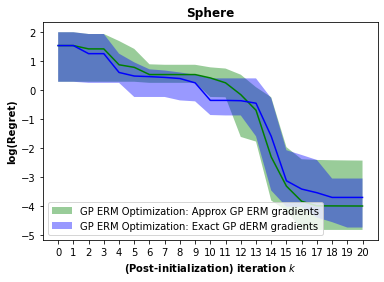

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(983.7368955612183, 947.7921721935272)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(2.9494047813305184, 3.0745517325030787)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(2.9556677884481353, 3.025774191897193)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(2.743422670085405, 2.9272629024386694)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(2.9283955021933403, 2.9984006578998113)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(2.9976203121496896, 3.050386969307234)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(3.0899361471237627, 3.122328847991191)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(2.973370957747016, 3.157144232787882)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(2.8888224956402704, 3.157897570224552)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(2.811298994164395, 3.129252181333068)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(3.0200045000605487, 3.245943603095179)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(2.807096583138649, 2.9150448843585863)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(2.9559179931570414, 2.94951365219758)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(2.906282737199976, 3.177913058958982)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(2.9336296201509637, 3.0736293312507224)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(2.987445076352641, 3.2121405970246784)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(2.970078497705658, 3.085644496555109)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(2.9279522617729494, 3.1111777423821017)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(2.8998301562406774, 3.0679631023002223)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(2.8315476529325307, 2.9994496851195547)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(2.940890438894323, 3.026072080852796)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(2.925930758324425, 3.075374576023909)

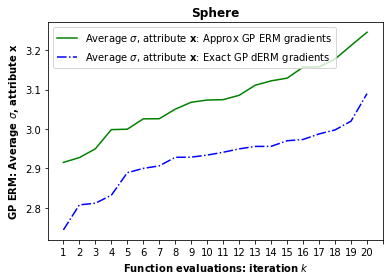

In [122]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Green', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Approx GP ERM gradients')
plt.plot(exact_stddev, color = 'Blue', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('GP ERM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=2) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
